# US Census Gradient Boosting

## Comparison of Gradient Boosting Classifier and CatBoost Classifier

In [41]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, make_scorer, RocCurveDisplay, ConfusionMatrixDisplay, precision_score, recall_score
from copy import copy
from time import time
import matplotlib.pyplot as plt
import category_encoders as ce
import catboost as cb

In [20]:
# Read US Census Data
df = pd.read_csv('data/us census data.csv')
df = df.replace("?","Other")

In [21]:
# Sample of raw data
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0,<=50K


In [22]:
# Data description
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,48842.0,NaN,NaN,NaN,38.643585,13.71051,17.0,28.0,37.0,48.0,90.0
workclass,48842,7,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,48842.0,NaN,NaN,NaN,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital-status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,48842,15,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours-per-week,48842.0,NaN,NaN,NaN,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


From the data description, we can see that we have some categorical features ('workclass','education','marital-status', ...). Natively, Sklearn's Gradient Boosting Classifier does not handle categorical variables so we must encode them. For this question, we will be using Ordinal Encoding, but we will later compare with Binary Encoding. CatBoost does support categorical features, so we will continue forward with an encoded dataset and a non-encoded dataset.

In [23]:
# Encode categorical variables according to selected encoding method
def encode_df(df, encode_method):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    y = LabelEncoder().fit_transform(y)
    encoder = encode_method(cols=X.iloc[:,np.where(X.dtypes == object)[0]].columns,return_df=True)
    X = encoder.fit_transform(X)

    return pd.concat((X,pd.Series(y).rename('income')),axis=1)

In [24]:
# Split data into features and targets
X, y = df.iloc[:,:-1], df.iloc[:,-1]
# Create non-encoded train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Encode dataframe using function
enc_df = encode_df(df, ce.OrdinalEncoder)
# Split encoded data into features and targets
X_enc, y_enc = enc_df.iloc[:,:-1], enc_df.iloc[:,-1]
# Create encoded train and test sets with same state as original data
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc,y_enc,test_size=0.2, random_state=1)

In [25]:
# Perform a grid search to find best parameters for Gradient Boosting Classifier
# Parameters tuned: Learning Rate, Max Depth, Number of Estimators
# Scoring based on test accuracy and fit time, using 5-fold cross validation
# Returns a DataFrame with the results of each parameter combination

scoring = {'accuracy': make_scorer(accuracy_score)}
parameters = {
    "learning_rate": [0.05, 0.1, 0.2, 0.5],
    "max_depth":[3,4,5],
    "n_estimators": [100,200,300,400,500]
}
gbc_gs = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)
gbc_gs.fit(X_train_enc, y_train_enc)
gbc_df = pd.DataFrame.from_dict(gbc_gs.cv_results_)

In [42]:
gbc_df[['mean_fit_time','mean_test_accuracy','param_learning_rate','param_max_depth','param_n_estimators']]

,mean_fit_time,mean_test_accuracy,param_learning_rate,param_max_depth,param_n_estimators
0,4.127405,0.855425,0.05,3,100
1,8.266173,0.864177,0.05,3,200
2,12.627592,0.868375,0.05,3,300
3,16.762416,0.870397,0.05,3,400
4,21.251635,0.871446,0.05,3,500
5,5.424201,0.861055,0.05,4,100
6,11.312760,0.870013,0.05,4,200
7,17.546625,0.871727,0.05,4,300
8,24.128494,0.873007,0.05,4,400
9,28.912201,0.873493,0.05,4,500


In [27]:
# Perform a grid search to find best parameters for CatBoost Classifier
# Parameters tuned: Max Depth, Number of Estimators
# Note: CatBoost automatically finds near-optimal learning rate based on other parameters
# Scoring based on test accuracy and fit time, using 5-fold cross validation
# Returns a DataFrame with the results of each parameter combination

cat_features_indices = np.where(X_train.dtypes == 'object')[0]
cbc = cb.CatBoostClassifier(logging_level='Silent',eval_metric = 'Accuracy',cat_features=cat_features_indices)
parameters = {
    "max_depth":[2,3,4,5,6,7,8],
    "n_estimators": [100,200,300,400,500]
}
cbc_gs = GridSearchCV(cbc, parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)
cbc_gs.fit(X_train, y_train)
cbc_df=pd.DataFrame.from_dict(cbc_gs.cv_results_)

In [43]:
cbc_df[['mean_fit_time','mean_test_accuracy','param_max_depth','param_n_estimators']]

,mean_fit_time,mean_test_accuracy,param_max_depth,param_n_estimators
0,4.614085,0.866430,2,100
1,15.108700,0.871139,2,200
2,22.936394,0.871088,2,300
3,30.772016,0.871216,2,400
4,38.120181,0.870960,2,500
5,6.242040,0.869731,3,100
6,20.660732,0.873340,3,200
7,32.096352,0.873212,3,300
8,41.683279,0.873493,3,400
9,52.472468,0.874031,3,500


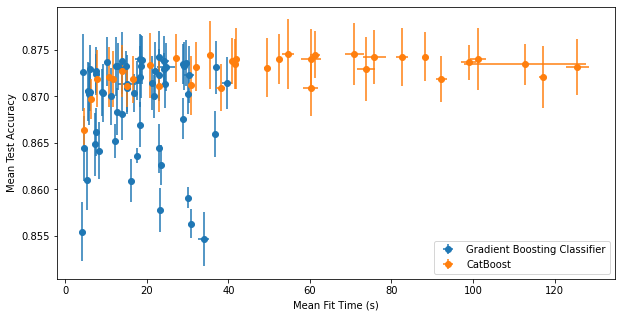

In [29]:
# Plot of mean fit time vs. mean test accuracy with standard deviation across 5 folds
# Visualization of trade-off between accuracy and fit time
plt.figure(figsize=(10,5))
plt.errorbar(gbc_df['mean_fit_time'],gbc_df['mean_test_accuracy'],
             xerr=gbc_df['std_fit_time'],yerr=gbc_df['std_test_accuracy'],
             fmt="o", color="tab:blue")
plt.errorbar(cbc_df['mean_fit_time'],cbc_df['mean_test_accuracy'],
             xerr=cbc_df['std_fit_time'],yerr=cbc_df['std_test_accuracy'],
             fmt="o", color="tab:orange")
plt.legend(['Gradient Boosting Classifier','CatBoost'],loc='lower right')
plt.xlabel("Mean Fit Time (s)")
plt.ylabel("Mean Test Accuracy")
plt.show()

From this plot, we can see the trade-offs between accuracy and fit time for some of the parameters in the grid search. We can also see how CatBoost effectively determines the learning rate for the given parameters as all the points are more optimized, as opposed to the 'random' scattering of points from Gradient Boosting Classifier due to a poor mixture of parameters for some points.

We can also observe that with the variance between folds, many of the accuracy values overlap with each other's error bars. We can also observe that the fit time for the Gradient Boosting Classifier has much less variance than CatBoost.

In [30]:
# Method for selecting best parameters accounting for trade-off between accuracy and fit time
# The model with the fastest time, that still fits within the uncertainty range of the most accurate model is selected
def get_best_params(gs_results_df):
    max_ind = gs_results_df['mean_test_accuracy'].argmax()
    thresh = gs_results_df['mean_test_accuracy'][max_ind] - gs_results_df['std_test_accuracy'][max_ind]
    min_ind = gs_results_df[gs_results_df['mean_test_accuracy'] >= thresh]['mean_fit_time'].argmin()
    ind = gs_results_df.index[gs_results_df['mean_test_accuracy'] >= thresh][min_ind]
    return gs_results_df['params'][ind]

As the exact requirements for these models aren't available, I have decided to choose the model parameters based on the tradeoff between accuracy and fit time. The parameters chosen are those which give the fastest model whose accuracy lies within the uncertainty range of the most accurate model.

Other selection methods could be used such as selecting purely best accuracy or optimizing sensitivity/specificity.

In [44]:
# Method to evaluate model on withheld test set
# Metrics used: Accuracy, Precision, Recall, ROC Curve + AUC, Confusion Matrix
def evaluate_model(model, X_test, y_test, verbose=True):
    y_pred = model.predict(X_test)
    label_encoder = LabelEncoder()
    y_test_enc, y_pred_enc = label_encoder.fit_transform(y_test), label_encoder.fit_transform(y_pred)
    if verbose:
        RocCurveDisplay.from_estimator(model,X_test,y_test)
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')

    return accuracy_score(y_test,y_pred), precision_score(y_test_enc,y_pred_enc), recall_score(y_test_enc,y_pred_enc)

Best Parameters for Gradient Boosting Classifier:
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Metrics for Gradient Boosting Classifier:
Fitting time:  4.351958990097046
Accuracy: 87.16 %
Precision: 0.6494
Recall: 0.7778


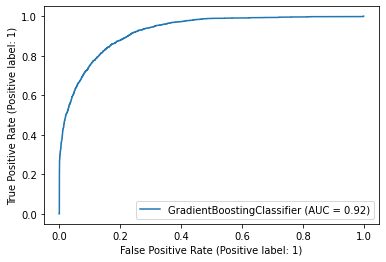

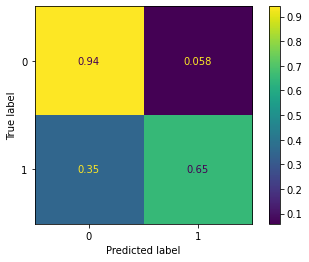

In [45]:
# Display and evaluate model with best parameters for Gradient Boosting Classifier
print("Best Parameters for Gradient Boosting Classifier:")
gbc_params = get_best_params(gbc_df)
print(gbc_params)
start = time()
gbc = GradientBoostingClassifier(**gbc_params)
gbc.fit(X_train_enc,y_train_enc)
end = time()
gbc_ft = end-start
gbc_acc, gbc_re, gbc_pr = evaluate_model(gbc,X_test_enc,y_test_enc)
print("Metrics for Gradient Boosting Classifier:")
print("Fitting time: ",gbc_ft)
print("Accuracy:",np.round(gbc_acc*100,2),"%")
print("Precision:",np.round(gbc_pr,4))
print("Recall:",np.round(gbc_re,4))

Best Parameters for CatBoost Classifier:
{'max_depth': 4, 'n_estimators': 100}
Metrics for Gradient Boosting Classifier:
Fitting time:  2.922657012939453
Accuracy: 86.87 %
Precision: 0.6323
Recall: 0.7776


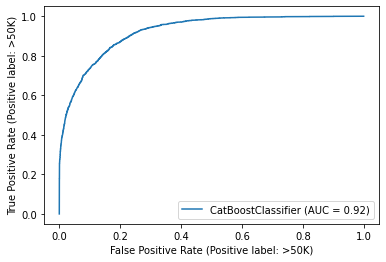

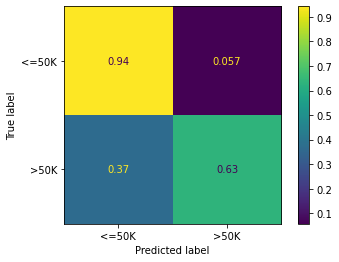

In [46]:
# Display and evaluate model with best parameters for CatBoost Classifier
train_dataset = cb.Pool(X_train,y_train,cat_features=cat_features_indices)
test_dataset = cb.Pool(X_test,y_test,cat_features=cat_features_indices)
print("Best Parameters for CatBoost Classifier:")
cbc_params = get_best_params(cbc_df)
print(cbc_params)
start = time()
cbc = cb.CatBoostClassifier(logging_level='Silent',
                            cat_features=cat_features_indices,
                            **cbc_params,
                            eval_metric='Accuracy'
                            )
cbc.fit(train_dataset,eval_set=test_dataset,plot=False)
end = time()
cbc_ft = end-start
print("Metrics for Gradient Boosting Classifier:")
print("Fitting time: ",cbc_ft)
cbc_acc, cbc_re, cbc_pr = evaluate_model(cbc,X_test,y_test)
print("Accuracy:",np.round(cbc_acc*100,2),"%")
print("Precision:",np.round(cbc_pr,4))
print("Recall:",np.round(cbc_re,4))

In [47]:
# Closer inspection of evaluation results between both models
pd.DataFrame([[gbc_ft,cbc_ft],[gbc_acc,cbc_acc],[gbc_pr,cbc_pr],[gbc_re,cbc_re]], ["Fit Time","Accuracy","Precision","Recall"],["Gradient Boosting Classifier","CatBoost"]).round(4)

,Gradient Boosting Classifier,CatBoost
Fit Time,4.3520,2.9227
Accuracy,0.8716,0.8687
Precision,0.6494,0.6323
Recall,0.7778,0.7776


Based on my method for parameter selection, we end up with a Gradient Boosting Classifier that performs better according to the accuracy, precision, and recall but has a slower fit time than the CatBoost. The differences observed are quite small, and depending on the required performance of the models, CatBoost could be selected due to the faster fit time.

Both models perform quite similarly overall and could each be tuned for either speed or accuracy. CatBoost could be the easier choice here as it can handle categorical features without the need for encoding, saving some computation and time while preprocessing the data.

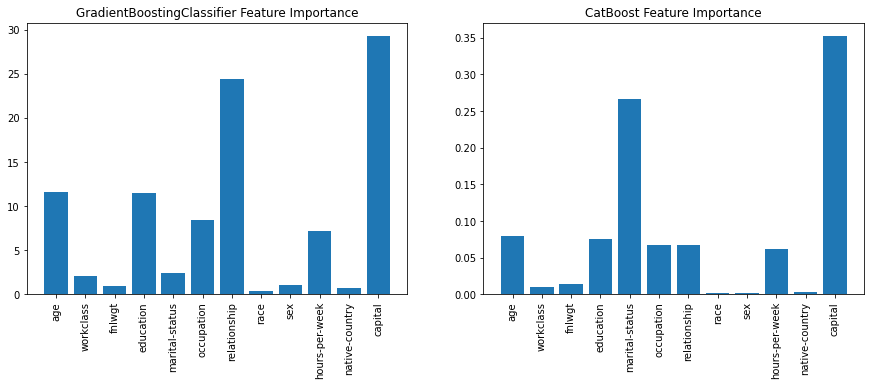

In [35]:
# Plot variable importance of both models
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("GradientBoostingClassifier Feature Importance")
plt.bar(df.columns[:-1],cbc.get_feature_importance());
plt.xticks(rotation=90);
plt.subplot(122)
plt.title("CatBoost Feature Importance")
plt.bar(df.columns[:-1],gbc.feature_importances_);
plt.xticks(rotation=90);

Here we can see the variable importance for both models.

## Categorical Encoding Investigation

The feature 'native-country' has over 40 categories. The sklearn model does not natively support categorical features so I had to make the decision to use Ordinal Encoding. However, CatBoost does support categorical features. For features with few values, CatBoost uses One-Hot Encoding (features with 2 values by default on CPU). Otherwise, CatBoost will transform categorical variables to numerical features during classification based on combinations of categorical features ([more info here](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)).

In [36]:
# Encode 'native-country' as either 'United-States' or 'Other'
bin_df = copy(df)
bin_df.loc[bin_df['native-country'] != 'United-States', 'native-country'] = 'Other'

<BarContainer object of 2 artists>

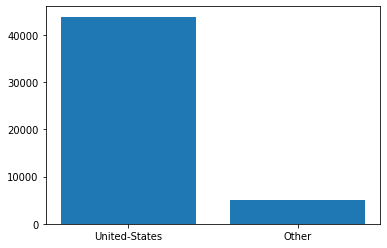

In [37]:
# Show plot of 'United-States' counts vs. 'Other' counts
plt.bar(bin_df['native-country'].unique(),bin_df['native-country'].value_counts())

It can be seen that the majority of the 'native-country' feature has 'United-States' as the value compared to all other values combined. If we were to encode this variable using One-Hot encoding, it would result in a very sparse set of features, even though the majority of the values are 'United-States'. This would negatively effect computation time.

In [51]:
# Method to compare Ordinal Encoding to OneHot encoding
def compare_encoding(name_list,df_list,encode_list,iters=10):
    out = pd.DataFrame(columns=["name","mean_time","std-time","accuracy","precision","recall"])
    for i, name in enumerate(name_list):
        times = []
        accs = []
        prs = []
        res = []
        for j in range(iters):
            df = encode_df(df_list[i],encode_list[i])
            X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.2)
            start = time()
            gbc = GradientBoostingClassifier(learning_rate=0.5,max_depth=3,n_estimators=100)
            gbc.fit(X_train,y_train)
            end = time()
            times.append(end-start)

            acc, pr, re = evaluate_model(gbc,X_test,y_test,verbose=False)
            accs.append(acc)
            prs.append(pr)
            res.append(re)

        mean_time = np.mean(times)
        std_time = np.std(times)
        out.loc[i] = [name,mean_time,std_time,np.mean(accs),np.mean(prs),np.mean(res)]

    return out

In [52]:
compare_encoding(["OneHot","Ordinal","BinaryOneHot","BinaryOrdinal"],
                 [df,df,bin_df,bin_df],
                 [ce.OneHotEncoder,ce.OrdinalEncoder,ce.OneHotEncoder,ce.OrdinalEncoder],iters=10)

,name,mean_time,std-time,accuracy,precision,recall
0,OneHot,8.308360,0.463808,0.872095,0.784884,0.648422
1,Ordinal,3.698715,0.034341,0.872423,0.784788,0.643543
2,BinaryOneHot,6.116987,0.077022,0.872740,0.775396,0.648829
3,BinaryOrdinal,3.708473,0.090137,0.871461,0.781548,0.643025


Here we have compared Ordinal and One-Hot encoding for both the original data, but also the data when we limit 'native-country' to be a binary feature comprised of 'United-States' and 'Other'. The Gradient Boosting Model is timed and evaluated with a differently shuffled dataset 10 times and the mean metrics are calculated.

From this table, we can see that the One-Hot encodings are much slower than Ordinal. In addition, when we don't restrict the values of 'native-country', there are around 2 seconds of additional time lost just due to this feature being one-hot encoded. This shows that the sparsity of the data is having negative impacts on the training speed of the model. By changing the encoding type to Ordinal, we can improve the computation time dramatically. This is important when considering the scaling of the dataset in terms of features and values for each feature, as well as the compounding effect of computation time when the model is deployed.

As far as the other metrics are concerned, the difference between the encoding times is minimal. It would therefor not be advised to use OneHot encoding for the 'native-country' variable.